In [13]:
# Import Library
from pydub import AudioSegment as au
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [14]:
recording_directory = "wav_recording/"
recording_name = "Accordion C3"
recording_format = "wav"
SAVE_FILE_AUTOMATICALLY = False

In [15]:
# Definisikan Fungsi FFT
def FFT(F_data, N_data):
  G_result = []
  for i in range(int(N_data/2)):
    g = 0
    for n in range(int(N_data/2)):
      g += F_data[2*n]/cmath.exp(2j*i*math.pi*(2*n)/N_data) + F_data[2*n + 1]/cmath.exp(2j*i*math.pi*(2*n + 1)/N_data)
    G_result.append(g)
  return G_result

#Definisikan Fungsi IFFT
def IFFT(G_data, N_data):
  F_result = []
  for i in range(N_data):
    f = 0
    for n in range(int(N_data/2)):
      f += (G_data[2*n]*cmath.exp(2j*i*math.pi*(2*n)/N_data) + G_data[2*n + 1]*cmath.exp(2j*i*math.pi*(2*n + 1)/N_data))/N_data
    F_result.append(f)
  return F_result

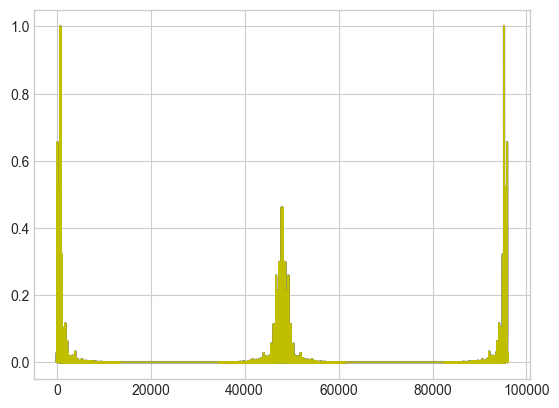

In [16]:
# Import File Audio
t_initial = 5E3 #(ms)
t_sample = 1E3 #(ms)
file_path = recording_directory + recording_name + "." + recording_format
file_audio = au.from_file(file=file_path, format=recording_format)
sample_audio = file_audio[t_initial:(t_initial + t_sample)]._data
F = []
for i in range(len(sample_audio)//2):
    audio_data = int.from_bytes(sample_audio[2*i:(2*i + 2)], 'little', signed=True)
    F.append(audio_data)
N = len(F)

# utk melihat kevalidan memakai index sebagai frekuensi
T = np.arange(0, t_sample, t_sample/N)
sr = N/t_sample * 1000 # sampling rate -> max freq detectable
freq_tick = np.linspace(0, sr, N)
G = np.fft.fft(F) # FFT
plt.plot(freq_tick, np.abs(G).real/np.amax(np.abs(G).real), color = "b")
plt.plot(np.abs(G).real/np.amax(np.abs(G).real), color = "y")
# plt.xlim([start_fwhm - 3, end_fwhm + 3])

# Analisa Fourier Transform Data Getaran Metode Euler
# frekuensi tinjauan harmonik pertama (dalam Hz)
h_low = 500
h_high = 550

# frekuensi tinjauan keseluruhan (dalam Hz)
f_low = 0
f_high = 2500

# inverse FFT
G_harmonics = np.append(np.append(np.zeros(f_low), G[f_low:(f_high + 1)]), np.zeros(N - f_high - 1))
F_harmonics = np.fft.ifft(G_harmonics)

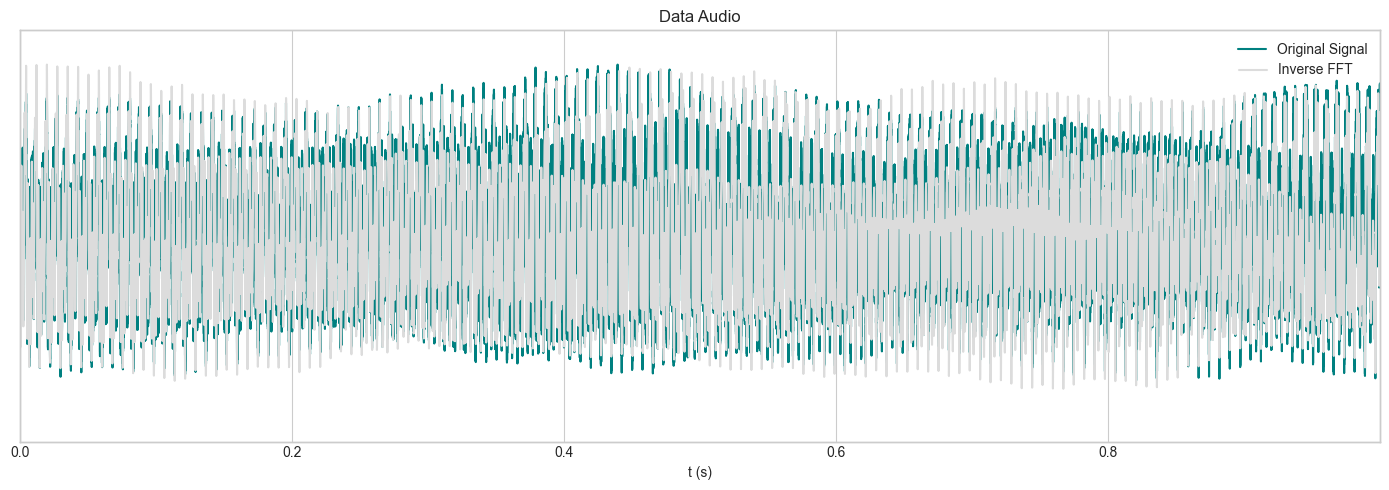

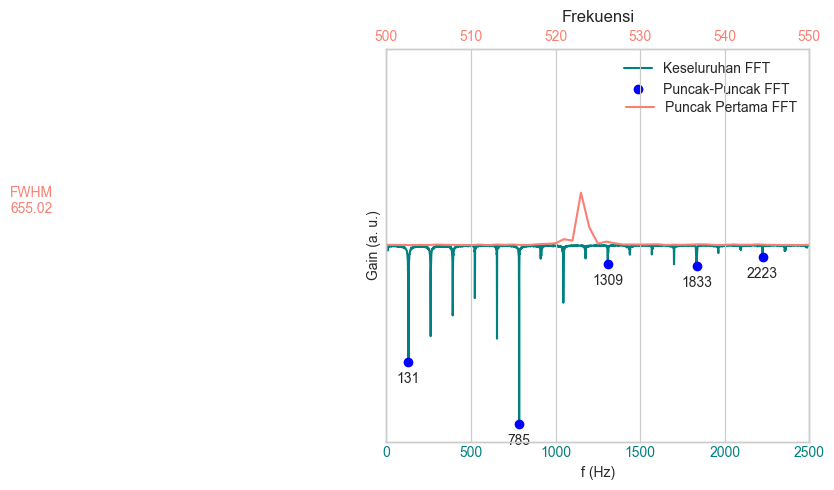

In [17]:
# Plot 1: Data Audio
plt.style.use('seaborn-v0_8-whitegrid')
fig1, ax1 = plt.subplots(figsize=(14, 5))
ax1.ticklabel_format(style='sci', scilimits=(-2, 2), axis='both')
ax1.set_title("Data Audio")
ax1.set_xlabel('t (s)')
ax1.plot(T * 1e-3, F/np.amax(np.abs(F)), color='teal', label="Original Signal") # normalized
ax1.axes.get_yaxis().set_visible(False)
ax1.set_xlim([T[0] * 1e-3, T[-1] * 1e-3])
ax1.set_ylim([- 1.2, 1.2])
ax1.legend(loc="upper right", bbox_to_anchor=(1, 1))
ax2 = ax1.twinx()
ax2.ticklabel_format(style='sci', scilimits=(-2, 2), axis='both')
ax2.plot(T * 1e-3, F_harmonics.real / np.amax(np.abs(F_harmonics.real)), color='gainsboro', label="Inverse FFT    ") # normalized
ax2.axes.get_yaxis().set_visible(False)
ax2.set_ylim([- 1.2, 1.2])
fig1.tight_layout()
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.95))

# Save the figure with high resolution
if(SAVE_FILE_AUTOMATICALLY):
    plt.savefig(f'figs/{recording_name} audio.png', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()

# Plot 2: Frekuensi
fig2, ax3 = plt.subplots(figsize=(14, 5))
ax3.ticklabel_format(style='sci', scilimits=(-2, 2), axis='y')
ax3.set_title("Frekuensi")
ax3.set_xlabel('f (Hz)')
ax3.set_ylabel('Gain (a. u.)')
G_neg = -np.abs(G).real / np.amax(np.abs(G).real)
peaks, _ = find_peaks(- G_neg, distance=300, height = 0.01)  # Cari puncak negatif
ax3.plot(
    G_neg, 
    color='teal', linestyle='-', marker=' ', linewidth=1.5, label="Keseluruhan FFT       "
)
ax3.plot(peaks, G_neg[peaks], color = "b", linestyle = " ", marker = "o", label="Puncak-Puncak FFT")  # Tandai puncak negatif
# Annotate each peak with its x-coordinate
for peak in peaks:
    plt.annotate(f"{peak}", (peak, G_neg[peak]), textcoords="offset points", xytext=(0,-15), ha='center')

ax3.set_yticks([])
ax3.tick_params(axis='x', labelcolor='teal')
ax3.set_xlim([f_low, f_high])
ax3.legend(loc="upper right", bbox_to_anchor=(1, 1))
ax4 = ax3.twiny()
G_harmonics_norm = np.abs(G_harmonics).real / np.amax(np.abs(G_harmonics).real)
ax4.plot(
    G_harmonics_norm, 
    color='salmon', linestyle='-', marker=' ', linewidth=1.5, label="Puncak Pertama FFT"
)
ax4.tick_params(axis='x', labelcolor='salmon')
ax4.set_xlim([h_low, h_high])

# Hitung FWHM
half_max = np.max(G_harmonics_norm) / 2
indices = np.arange(len(G_harmonics_norm))
above_half_max = np.where(G_harmonics_norm >= half_max)[0]

# Interpolasi titik FWHM
if len(above_half_max) > 0:
    left_idx = above_half_max[0] - 1
    right_idx = above_half_max[-1] + 1

    # Pastikan indeks valid
    left_idx = max(left_idx, 0)
    right_idx = min(right_idx, len(G_harmonics_norm) - 1)

    # Interpolasi titik start dan end
    interp_func_left = interp1d(
        G_harmonics_norm[left_idx:left_idx + 2], 
        indices[left_idx:left_idx + 2],
        kind='linear'
    )
    start_fwhm = interp_func_left(half_max)
    
    interp_func_right = interp1d(
        G_harmonics_norm[(right_idx - 1):right_idx + 1], 
        indices[(right_idx - 1) :right_idx + 1],
        kind='linear'
    )
    end_fwhm = interp_func_right(half_max)

    start_stem = ax4.stem([start_fwhm], [0.5], linefmt = "--", markerfmt=" ")
    end_stem = ax4.stem([end_fwhm], [0.5], linefmt = "--", markerfmt=" ")
    start_stem[1].set_color("salmon")  # Set the color of the line
    end_stem[1].set_color("salmon")  # Set the color of the line

    # Tambahkan label lebar FWHM
    fwhm_width = end_fwhm - start_fwhm
    ax4.text(
        (start_fwhm + end_fwhm) / 2, half_max / 2,
        f"FWHM\n{fwhm_width:.2f}",
        color='salmon', ha='center', va='center', fontsize=10
    )

fig2.tight_layout()
ax4.legend(loc="upper right", bbox_to_anchor=(1, 0.9))

# Save the figure with high resolution
if(SAVE_FILE_AUTOMATICALLY):
    plt.savefig(f'figs/{recording_name} fft.png', dpi=300, bbox_inches='tight')  # Adjust dpi as needed
plt.show()
